<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/Automacao_de_Negocios_Rede_Neural_Formato_novo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uma variação do notebook original, sem split e uso do mês seguinte como validador

##Usar o novo padrão de arquivo, com mais atributos e resultado como TRUE/FALSE

# Início: Importação as bibliotecas e Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
import datetime
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [2]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/DOL_C_1M_14x8.csv", sep=";", decimal=",")

In [3]:
#converte o campo data (string) em formato de data
historic['DataFormatada'] = pd.to_datetime(historic['Data'], format='%d/%m/%Y')
historic.head()

,CodOp,Hora_Entrada,Hora_Saida,tempo,Data,Pentrada,Psaida,Entrada,Saida,Ganhos,Perdas,Evol,Resultado,Saldo_dia,Ganho_Trade,MÊS,Max_Aberto,K_entra,K_Saida,DIR,VOL_Acum,AGRE_Acum,DistZero,K_ENTRA_CdDelta_T01,CdDelta_T05,CdDelta_T010,CdDelta_T015,CdDelta_T020,CdDelta_T030,VolTot_1Min,VolTot_5Min,VolTot_10Min,VolTot_15Min,Vol_Delta_01m,Vol_Delta_05m,Vol_Delta_10m,Vol_Delta_15m,Num_Agre_01,Num_Agre_05,Num_Agre_10,...,SALDO_ITAU,SALDO_SANTANDER,Final_LUCRO_UBS,Final_LUCRO_IDEAL,Final_LUCRO_BTG,Final_LUCRO_JP_MORGAN,Final_LUCRO_GENIAL,Final_LUCRO_XP,Final_LUCRO_TULLETT,Final_LUCRO_BRADESCO,Final_LUCRO_ITAU,Final_LUCRO_SANTANDER,CD_Ang_Reta_Preco_5,CD_Correl_Reta_Preco_5,CD_Ang_Reta_Preco_10,CD_Correl_Reta_Preco_10,CD_Ang_Reta_Preco_15,CD_Correl_Reta_Preco_15,CD_Ang_Reta_Preco_30,CD_Correl_Reta_Preco_30,CD_Ang_Reta_Agre_5,CD_Correl_Reta_Agre_5,CD_Ang_Reta_Agre_10,CD_Correl_Reta_Agre_10,CD_Ang_Reta_Agre_15,CD_Correl_Reta_Agre_15,CD_Ang_Reta_Agre_30,CD_Correl_Reta_Agre_30,CDAgredia,IFR14_01,IFR14_05,IFR14_10,IFR21_01,IFR21_05,IFR21_10,Ampli_01,Ampli_05,MEP_Trade,MEN_Trade,DataFormatada
0,1,09:15:01,09:23:15,00:08:14,02/01/2019,"3.894,50","3.886,50",774,1033,0.0,8.0,-8.0,False,0.0,-8.0,1,0,15,25,C,12800,-200,6.5,15,3,1,1,0,0,790,790,890,790,200,2800,9000,11700,28,44,55.5,...,400.0,0.0,2000.0,0.0,2000.0,-2000.0,0.0,0.0,2000.0,0.0,0.0,0.0,54.0,0.44,4.0,0.04,-20.0,-0.20,0.0,0.0,42.0,0.74,10.0,0.36,-20.0,-0.60,0.0,0.0,-300.0,56.0,56.0,56.0,55.0,54.0,54.0,4.5,9.5,1.0,-8.0,2019-01-02
1,2,09:16:03,09:23:15,00:07:12,02/01/2019,"3.894,50","3.886,50",817,1033,0.0,8.0,-16.0,False,0.0,-8.0,1,0,15,25,C,12800,-400,4.5,15,3,1,1,0,0,750,790,890,790,240,2800,9000,11700,40,44,55.5,...,400.0,0.0,2000.0,0.0,2000.0,-2000.0,0.0,0.0,2000.0,0.0,0.0,0.0,-42.0,-0.50,2.0,0.04,-44.0,-0.56,0.0,0.0,-10.0,-0.32,14.0,0.52,-16.0,-0.50,0.0,0.0,-420.0,42.0,54.0,54.0,56.0,53.0,53.0,3.8,9.5,1.0,-8.0,2019-01-02
2,3,09:17:05,09:23:14,00:06:10,02/01/2019,"3.895,00","3.887,00",853,1027,0.0,8.0,-24.0,False,0.0,-8.0,1,0,15,25,C,12800,-400,6.0,15,3,1,1,0,0,720,790,890,790,240,2800,9000,11700,40,44,55.5,...,400.0,0.0,2000.0,0.0,2000.0,-2000.0,0.0,0.0,2000.0,0.0,0.0,0.0,-54.0,-0.72,2.0,0.02,-38.0,-0.48,0.0,0.0,-32.0,-0.98,12.0,0.42,-12.0,-0.42,0.0,0.0,-445.0,42.0,41.0,41.0,55.0,44.0,44.0,3.5,9.5,1.0,-8.0,2019-01-02
3,4,09:18:13,09:23:53,00:05:40,02/01/2019,"3.891,00","3.883,00",889,1085,0.0,8.0,-32.0,False,0.0,-8.0,1,0,20,25,C,12800,-600,3.0,20,3,1,1,0,0,700,790,890,790,280,2800,9000,11700,32,44,55.5,...,400.0,0.0,2000.0,0.0,2000.0,-2000.0,0.0,0.0,2000.0,0.0,0.0,0.0,-50.0,-0.72,-18.0,-0.20,-38.0,-0.48,0.0,0.0,-36.0,-0.98,2.0,0.04,-14.0,-0.46,0.0,0.0,-570.0,34.0,44.0,44.0,53.0,46.0,46.0,3.3,9.5,0.0,-8.0,2019-01-02
4,5,09:19:19,09:39:49,00:20:31,02/01/2019,"3.889,00","3.881,00",946,1499,0.0,8.0,-40.0,False,0.0,-8.0,1,0,20,40,C,12800,-800,0.5,20,3,1,1,0,0,680,790,890,790,440,2800,9000,11700,46,44,55.5,...,400.0,0.0,2000.0,0.0,2000.0,-2000.0,0.0,-2000.0,2000.0,2000.0,0.0,0.0,-68.0,-0.82,-34.0,-0.34,-36.0,-0.48,0.0,0.0,-52.0,-0.94,-12.0,-0.30,-12.0,-0.44,0.0,0.0,-855.0,36.0,39.0,39.0,50.0,43.0,43.0,3.2,9.5,0.0,-8.0,2019-01-02


In [4]:
#separa um mês em cada  dataframe e faz todas as operações de preparação do daframe criado
variables = locals()
for i in range(1,13):
  mes = str(i).zfill(2)
  variables["mes{0}".format(mes)] = historic[historic['DataFormatada'].dt.month == i]
  #separa o target e o código da operação
  variables["target{0}".format(mes)] = variables["mes{0}".format(mes)][['CodOp', 'Resultado']].copy()
  #indica o campo CodOp como índice nos 2 dataframes (para conferência futura)
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].set_index('CodOp')
  variables["target{0}".format(mes)] = variables["target{0}".format(mes)].set_index('CodOp')
  #apaga o campo target do dataframe original e outros campos já definidos como não necessários
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].drop(['Resultado', 'Hora_Entrada', 'Hora_Saida',
                                                                          'tempo', 'Data', 'Pentrada', 'Psaida', 'Ganhos',
                                                                          'Perdas', 'Evol', 'Saldo_dia', 'Ganho_Trade', 'MÊS', 'Max_Aberto', 
                                                                          'K_entra', 'K_Saida', 'DIR', 'DataFormatada', 'MEP_Trade', 'MEN_Trade'], axis=1)

# Criando um arquivo separado com base no mês para teste

In [5]:
#escolhas dos meses para tratar
mesesTreino = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'] #train
mesValidacao = '12' #test

In [6]:
#prepara os datasets de acordo com os meses informados
variables = locals()
X_train = variables["mes{}".format(mesesTreino[0])].copy()
for i in range(1, len(mesesTreino)):
  X_train = X_train.append(variables["mes{}".format(mesesTreino[i])])
print(X_train.shape)

X_test = variables["mes{}".format(mesValidacao)].copy()
print(X_test.shape)

#e também dos objetivos para validação
y_train = variables["target{}".format(mesesTreino[0])].copy()
for i in range(1, len(mesesTreino)):
  y_train = y_train.append(variables["target{}".format(mesesTreino[i])])
print(y_train.shape)

y_test = variables["target{}".format(mesValidacao)].copy()
print(y_test.shape)
#converte em array
y_test = y_test.values.ravel()

(100697, 116)
(8211, 116)
(100697, 1)
(8211, 1)


# Modelagem

In [27]:
#define a apresentação dos resultados das modelagens
def mostraResultado(y_test, valoresPrevistos):
  #lista quantidade de acertos
  contaOk = 0
  contaNao = 0
  contaDesconsiderados = 0
  for i in range(0, len(y_test)):
    if int(valoresPrevistos[i]) == True  and y_test[i] == True:
      contaOk += 1
    elif int(valoresPrevistos[i]) == True  and y_test[i] == False:
      contaNao += 1
    else:
      contaDesconsiderados += 1

  print("Quantidade de resultados OK: {}\nQuantidade de resultados Não: {}".format(contaOk, contaNao))
  if contaOk+contaNao > 0:
    print("Percentual de acertos: {:.1f}%".format(contaOk/(contaOk+contaNao)*100))
  print("Quantidade de resultados desconsiderados: {}".format(contaDesconsiderados))

###Modelo Rede Neural

In [31]:
model = Sequential()
model.add(Dense(116, activation='relu', input_dim=116))
model.add(Dense(228, activation='relu'))
model.add(Dense(58, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'rmsprop',
              metrics=['accuracy']
              )

history = model.fit(X_train, y_train, epochs=100, batch_size=500, validation_data=(X_test, y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 116)               13572     
_________________________________________________________________
dense_20 (Dense)             (None, 228)               26676     
_________________________________________________________________
dense_21 (Dense)             (None, 58)                13282     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 59        
Total params: 53,589
Trainable params: 53,589
Non-trainable params: 0
_________________________________________________________________
Train on 100697 samples, validate on 8211 samples
Epoch 1/100
100697/100697 [==============================] - 2s 17us/step - loss: 617.7891 - accuracy: 0.5589 - val_loss: 3183.1494 - val_accuracy: 0.4859
Epoch 2/100
100697/100697 [================

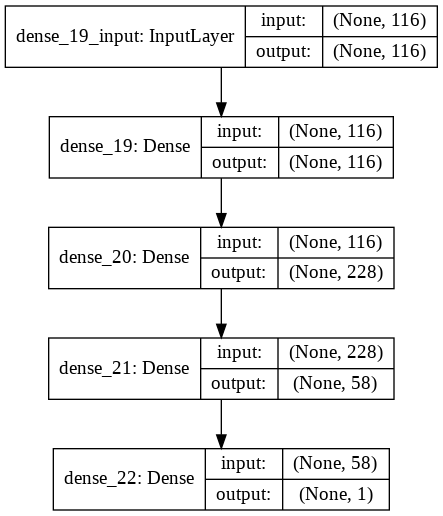

In [32]:
#plota o modelo
plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)
print('Acurácia: ', test_acc)

Acurácia:  0.629521369934082


In [34]:
#faz predição com dados de validacao
valoresPrevistos = model.predict_classes(X_test)
#resultado = 1 ou 2
mostraResultado(y_test, valoresPrevistos)

Quantidade de resultados OK: 126
Quantidade de resultados Não: 28
Percentual de acertos: 81.8%
Quantidade de resultados desconsiderados: 8057


In [35]:
valoresPrevistos

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

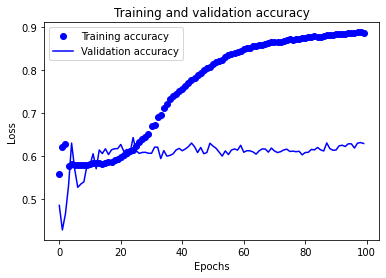

In [36]:
epochs = range(0, len(history.history['accuracy']))
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

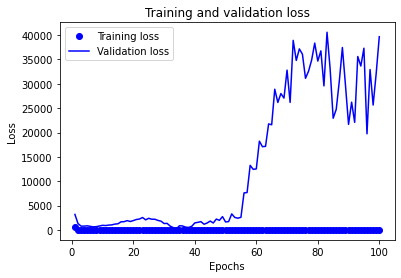

In [37]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exportação do modelo divididos para conferência

In [38]:
#salva o modelo para uso posterior em outro notebook em produção
arquivo_modelo = 'modeloRN.pkl'
pickle.dump(model, open(arquivo_modelo, 'wb'))